In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import galsim
import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [19]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

#pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')
# For testing the new internal data release. If you need the public data release, you can use the above one.
pdr2 = hsc.Hsc(dr='dr3', rerun='s20a_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_wide/s20a_wide_tables.fits


## Connecting the image with HSC photometric measurements

In [3]:
coord_1 = SkyCoord(138.808426, 3.703354, frame='icrs', unit='deg')
coord_1 = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')

# Physical size
s_phy = 100.0 * u.kpc
#redshift = 0.15
redshift = 0.20

### Get the i-band cutout image 

In [4]:
cutout = task.hsc_cutout(
    coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
    archive=pdr2, use_saved=False, verbose=True, 
    save_output=False)

# Retrieving cutout image in filter: i


### Get the i-band PSF image

In [5]:
psf_i = task.hsc_psf(coord_1, filters='i', archive=pdr2, save_output=False)[0].data

# Retrieving coadd PSF model in filter: i


### Search for HSC objects in the cutout

* Options:
    - `psf = True`: get forced PSF photometry
    - `cmodel = True`: get forced CModel photometry
    - `aper = True`: get the PSF-matched aperture photometry
    - `shape = True`: get the forced SDSS shapes
    - `meas = [grizy]`: get the independent photometric measurements in a specific band
    - `flux = False`: get the flux instead of AB magnitude

In [6]:
# Increase the box size a little to include objects just at the edge of the cutout
s_box = s_phy * 1.05

cutout_objs = task.hsc_box_search(
    coord_1, box_size=s_box, redshift=redshift, archive=pdr2,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

# WCS of the image
cutout_wcs = wcs.WCS(cutout[1].header)

Waiting for query to finish... [Done]
# 166/176 objects are clean.


### Visualize the detection and the shape of the objects

* Can highlight the "bad" objects using `show_bad = True` (**black circle**)
* Can only show the clean objects using `show_clean = True` 
* Point sources are shown as **Light blue cross**:
    - Not all these "point sources" are actually stars. 
    - You can also show the "SDSS shape" for point sources using `show_sdssshape=True`
* Extended objects are shown using **brown ellipse**.
    - Can show one ellipse using a `fracDev`-weighted shape. 
    - Can show two ellipses per object: one for `cmodel.exp`, one for `cmodel.dev`.
* You can also color-coded the ellipses for galaxies using their CModel magnitude in one band
    - Set `show_mag = True`, and provides a filter name using `band = 'i'`.
    
#### `SDSSShape` for stars and weighted shape for galaxies

In [12]:
isinstance(cutout, fits.HDUList)

True

In [13]:
cutout

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x129e2fcd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x129f165e0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x129f24700>, <astropy.io.fits.hdu.image.ImageHDU object at 0x129f249a0>]

167 176
# 160/167 objects are clean.
# There are 20 point sources on the cutout
# There are 147 extended sources on the cutout


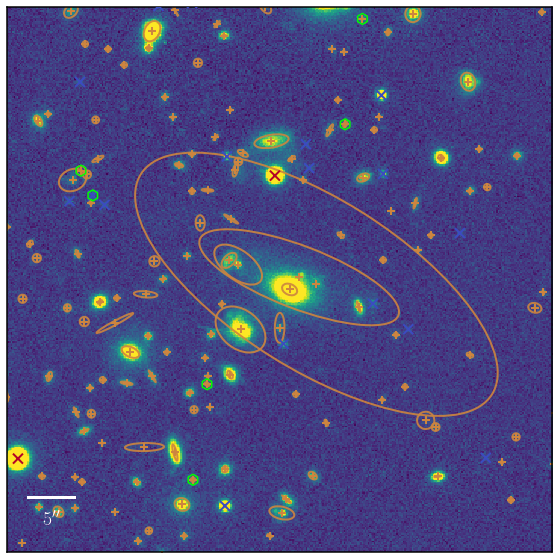

In [20]:
flux_mask = ((cutout_objs['i_psf_mag'] <= 26.5) | (cutout_objs['i_cmodel_mag'] <= 26.5))
clean_mask = catalog.select_clean_objects(cutout_objs, check_flag=None)

objs_use = cutout_objs[clean_mask & flux_mask]

print(len(objs_use), len(cutout_objs))

_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10)

#### Only label point sources, show the ellipses of both `Exp` and `DeV` components in `CModel` 

# 160/167 objects are clean.
# There are 20 point sources on the cutout
# There are 147 extended sources on the cutout


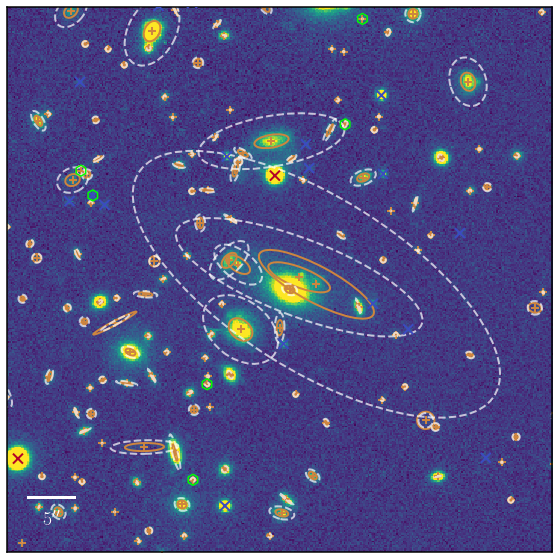

In [21]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10, show_weighted=False)

#### Color-coded the weighted-ellipse for galaxies

# 160/167 objects are clean.
# There are 20 point sources on the cutout
# There are 147 extended sources on the cutout


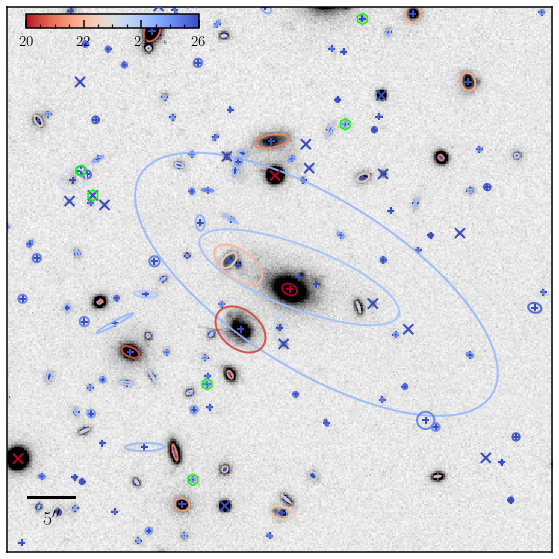

In [22]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10, band='i', cmap='Greys', 
    show_mag=True, scale_bar_color='k')

#### Color-coded both ellipese for `Exp` and `DeV` components

# 160/167 objects are clean.
# There are 20 point sources on the cutout
# There are 147 extended sources on the cutout


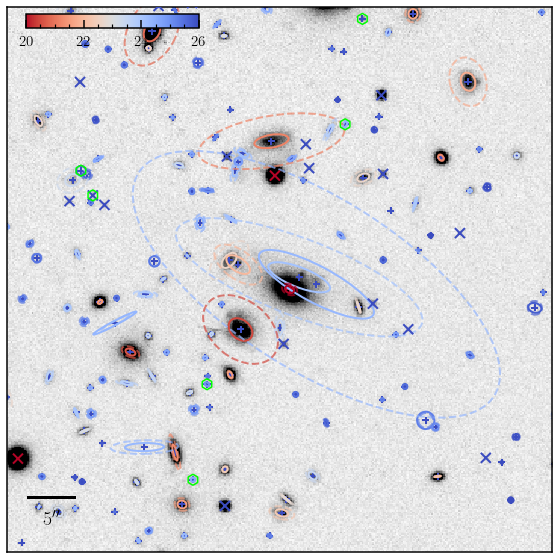

In [23]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, show_clean=False, xsize=10, band='i', cmap='Greys', 
    show_mag=True, show_weighted=False, scale_bar_color='k')

### Show the HSC CModel and PSF models

In [24]:
objs_test = catalog.world_to_image(objs_use, cutout_wcs, update=True)

objs_test = catalog.moments_to_shape(
    objs_test, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=True)

objs_test = catalog.moments_to_shape(
    objs_test, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=True)

167


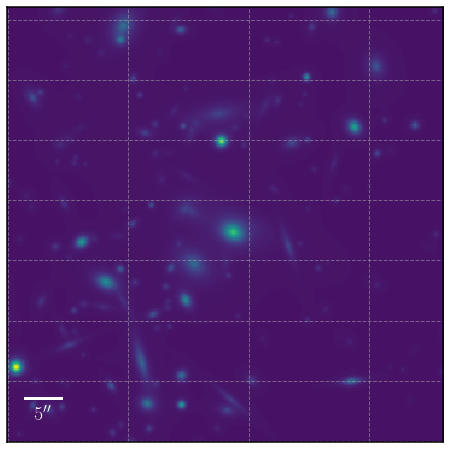

In [25]:
extended = 'i_extendedness'

objects = objs_test[(objs_test['psf_mag'] > 0) | (objs_test['cmodel_mag'] > 0)]
print(len(objects))

img_model = catalog.objects_to_galsim(cutout[1].data, objects, psf_model=psf_i)

_ = plotting.display_single(
    img_model, zmin=np.nanmin(cutout[1].data), zmax=np.nanmax(cutout[1].data))

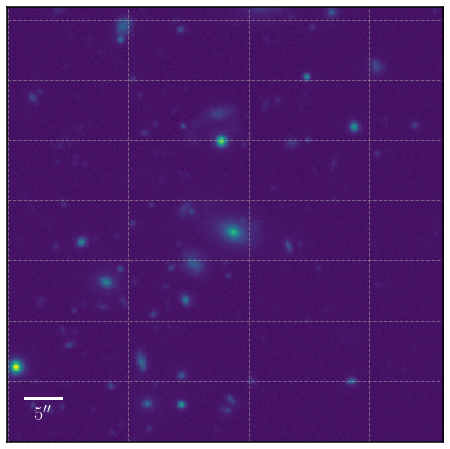

In [26]:
_ = plotting.display_single(
    cutout[1].data, zmin=np.nanmin(cutout[1].data), zmax=np.nanmax(cutout[1].data))

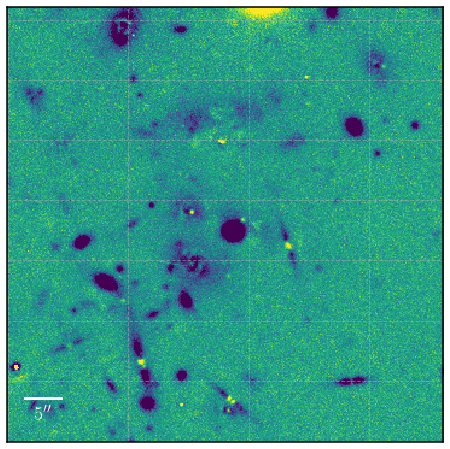

In [27]:
_ = plotting.display_single(
    cutout[1].data - img_model, scale='zscale')

In [28]:
x_clean, y_clean = catalog.world_to_image(cutout_clean, cutout_wcs, update=False)
x_dirty, y_dirty = catalog.world_to_image(cutout_objs[~clean_mask], cutout_wcs, update=False)

# Get the stars and show the SDSS shape
star_mask = cutout_clean['i_extendedness'] < 0.5
cutout_star = cutout_clean[star_mask]
x_star, y_star = x_clean[star_mask], y_clean[star_mask]
r_star, ba_star, pa_star = catalog.moments_to_shape(
    cutout_star, shape_type='i_sdssshape', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_star) > 0:
    print("# There are {} point sources on the cutout".format(len(cutout_star)))
else:
    print("# No point source is found!")

# Get the extended objects
gal_mask = ~star_mask
cutout_gal = cutout_clean[gal_mask]
x_gal, y_gal = x_clean[gal_mask], y_clean[gal_mask]
r_exp, ba_exp, pa_exp = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_dev, ba_dev, pa_dev = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_gal, ba_gal, pa_gal = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_ellipse', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_gal) > 0:
    print("# There are {} extended sources on the cutout".format(len(cutout_gal)))
else:
    print("# No point source is found!")

# There are 20 point sources on the cutout
# There are 146 extended sources on the cutout


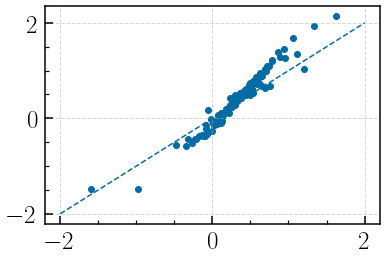

In [29]:
plt.scatter(np.log10(r_exp), np.log10(r_dev))
plt.plot([-2.0, 2.0], [-2.0, 2.0], linestyle='--')